In [2]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from tempfile import TemporaryDirectory

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

print(f"Device: {device}")

Device: cuda


In [8]:
zip_path = '/content/gdrive/MyDrive/datasets/forestvsbuilding.zip'

extract_path = '/content/gdrive/MyDrive/datasets/'

# Unzip the file
import zipfile
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List the contents of the extracted folder
import os
data = os.listdir(extract_path)
print("Extracted files:", data)

Extracted files: ['forestvsbuilding.zip', 'data']


### Data Preparation

In [11]:
# data augmentation and normalization for train set
# only normalization for test set

data_path = '/content/gdrive/MyDrive/datasets/data/'

transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
    ])


train_dataset = datasets.ImageFolder(root=os.path.join(data_path, 'train'), transform=transform)

# Load the testing dataset using ImageFolder
val_dataset = datasets.ImageFolder(root=os.path.join(data_path, 'val'), transform=transform)

# Define batch size
batch_size = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [12]:
# Check properties of the training dataset
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of training classes: {len(train_dataset.classes)}")
print("Classes in the training dataset:", train_dataset.classes)

# Check properties of the testing dataset
print(f"\nNumber of testing images: {len(val_dataset)}")
print(f"Number of testing classes: {len(val_dataset.classes)}")
print("Classes in the testing dataset:", val_dataset.classes)

Number of training images: 4443
Number of training classes: 2
Classes in the training dataset: ['buildings', 'forest']

Number of testing images: 911
Number of testing classes: 2
Classes in the testing dataset: ['buildings', 'forest']


In [14]:
def train_model(model, criterion, optimizer, scheduler, train_loader, test_loader, num_epochs=10, device='cuda'):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                    data_loader = train_loader
                else:
                    model.eval()   # Set model to evaluate mode
                    data_loader = test_loader

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in data_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / len(data_loader.dataset)
                epoch_acc = running_corrects.double() / len(data_loader.dataset)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [15]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 78.2MB/s]


In [16]:
 train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, train_loader, test_loader, num_epochs=10, device='cuda')

Epoch 0/9
----------
train Loss: 0.0651 Acc: 0.9786
val Loss: 0.0062 Acc: 1.0000

Epoch 1/9
----------
train Loss: 0.0129 Acc: 0.9968
val Loss: 0.0037 Acc: 1.0000

Epoch 2/9
----------
train Loss: 0.0059 Acc: 0.9995
val Loss: 0.0028 Acc: 1.0000

Epoch 3/9
----------
train Loss: 0.0062 Acc: 0.9989
val Loss: 0.0024 Acc: 1.0000

Epoch 4/9
----------
train Loss: 0.0054 Acc: 0.9989
val Loss: 0.0016 Acc: 1.0000

Epoch 5/9
----------
train Loss: 0.0022 Acc: 1.0000
val Loss: 0.0013 Acc: 1.0000

Epoch 6/9
----------
train Loss: 0.0035 Acc: 0.9995
val Loss: 0.0009 Acc: 1.0000

Epoch 7/9
----------
train Loss: 0.0018 Acc: 1.0000
val Loss: 0.0009 Acc: 1.0000

Epoch 8/9
----------
train Loss: 0.0025 Acc: 0.9998
val Loss: 0.0009 Acc: 1.0000

Epoch 9/9
----------
train Loss: 0.0024 Acc: 0.9995
val Loss: 0.0010 Acc: 1.0000

Training complete in 4m 23s
Best val Acc: 1.000000


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:

model_ft.eval()  # Set the model to evaluation mode

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


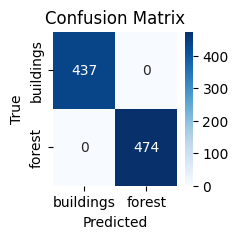

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
class_names = val_dataset.classes

plt.figure(figsize=(len(class_names), len(class_names)))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


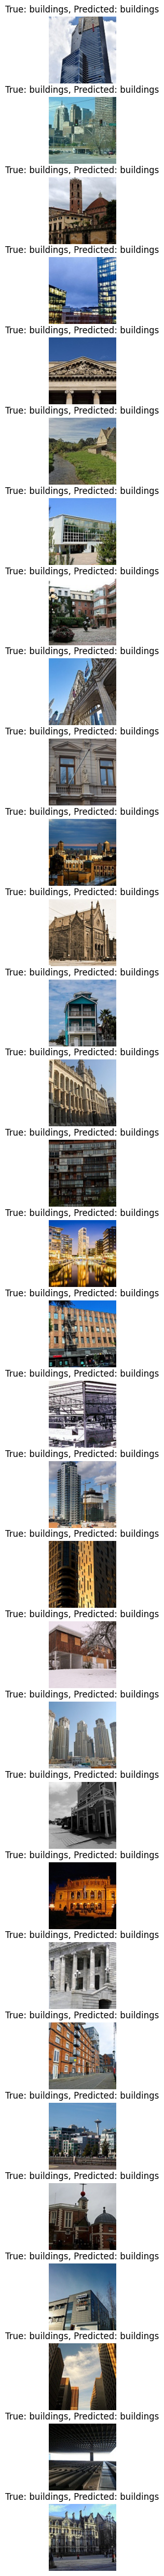

In [22]:
def show_predictions(images, labels, preds, classes):
    fig, axs = plt.subplots(len(images), 1, figsize=(5, 2 * len(images)))

    for i in range(len(images)):
        img = images[i].numpy().transpose((1, 2, 0))
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(f'True: {classes[labels[i]]}, Predicted: {classes[preds[i]]}')

    plt.show()

# Extract a batch of data from the test loader
test_batch_iter = iter(test_loader)
test_images, test_labels = next(test_batch_iter)

# Make predictions on the test batch
model_ft.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_outputs = model_ft(test_images.to(device))
    _, test_preds = torch.max(test_outputs, 1)

# Pass the classes variable to the show_predictions function
show_predictions(test_images, test_labels, test_preds.cpu().numpy(), val_dataset.classes)
